## Import Libraries


In [2]:
import time
import h5py
import librosa
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

from PyLTSpice import RawRead
from scipy.interpolate import PchipInterpolator

## Load and Resample LTSpice Data


In [11]:
spice_raw_path = '../ltspice/fuzz_static/Fuzz Static.raw'
spice_raw = RawRead(spice_raw_path)
print(spice_raw.get_trace_names())

time_raw = spice_raw.get_axis()
time_duration = time_raw[-1]
print(f'Time duration: {time_duration}')

v_in_raw = spice_raw.get_trace('V(input)').get_wave()
v_out_raw = spice_raw.get_trace('V(output)').get_wave()
alpha_lin = spice_raw.get_trace('V(alpha_lin)').get_wave()
alpha_vol = spice_raw.get_trace('V(alpha_vol)').get_wave()

fs_target = 48e3
ts_target = 1.0 / fs_target
num_samples = np.floor(time_duration * fs_target).astype(int) + 1
time_resample = np.linspace(0, time_duration, num_samples)

v_in = PchipInterpolator(time_raw, v_in_raw)(time_resample)
v_out = PchipInterpolator(time_raw, v_out_raw)(time_resample)
alpha_lin = PchipInterpolator(time_raw, alpha_lin)(time_resample)
alpha_vol = PchipInterpolator(time_raw, alpha_vol)(time_resample)

['time', 'V(n001)', 'V(n004)', 'V(n002)', 'V(n007)', 'V(n003)', 'V(n008)', 'V(n009)', 'V(n010)', 'V(output)', 'V(n005)', 'V(alpha_lin)', 'V(n006)', 'V(input)', 'V(alpha_vol)', 'I(R92)', 'I(R93)', 'I(R4)', 'I(R6)', 'Ic(Q1)', 'Ib(Q1)', 'Ie(Q1)', 'I(C94)', 'I(C91)', 'I(C81)', 'I(C1)', 'I(R5)', 'I(R3)', 'I(R81)', 'I(R72)', 'I(Rout)', 'I(Rin)', 'I(R12)', 'I(E1)', 'I(Vcc)', 'I(Vin)', 'I(V2)', 'I(V1)']
Time duration: 0.7821354167673885


## Plot LTSpice Data (Optional)


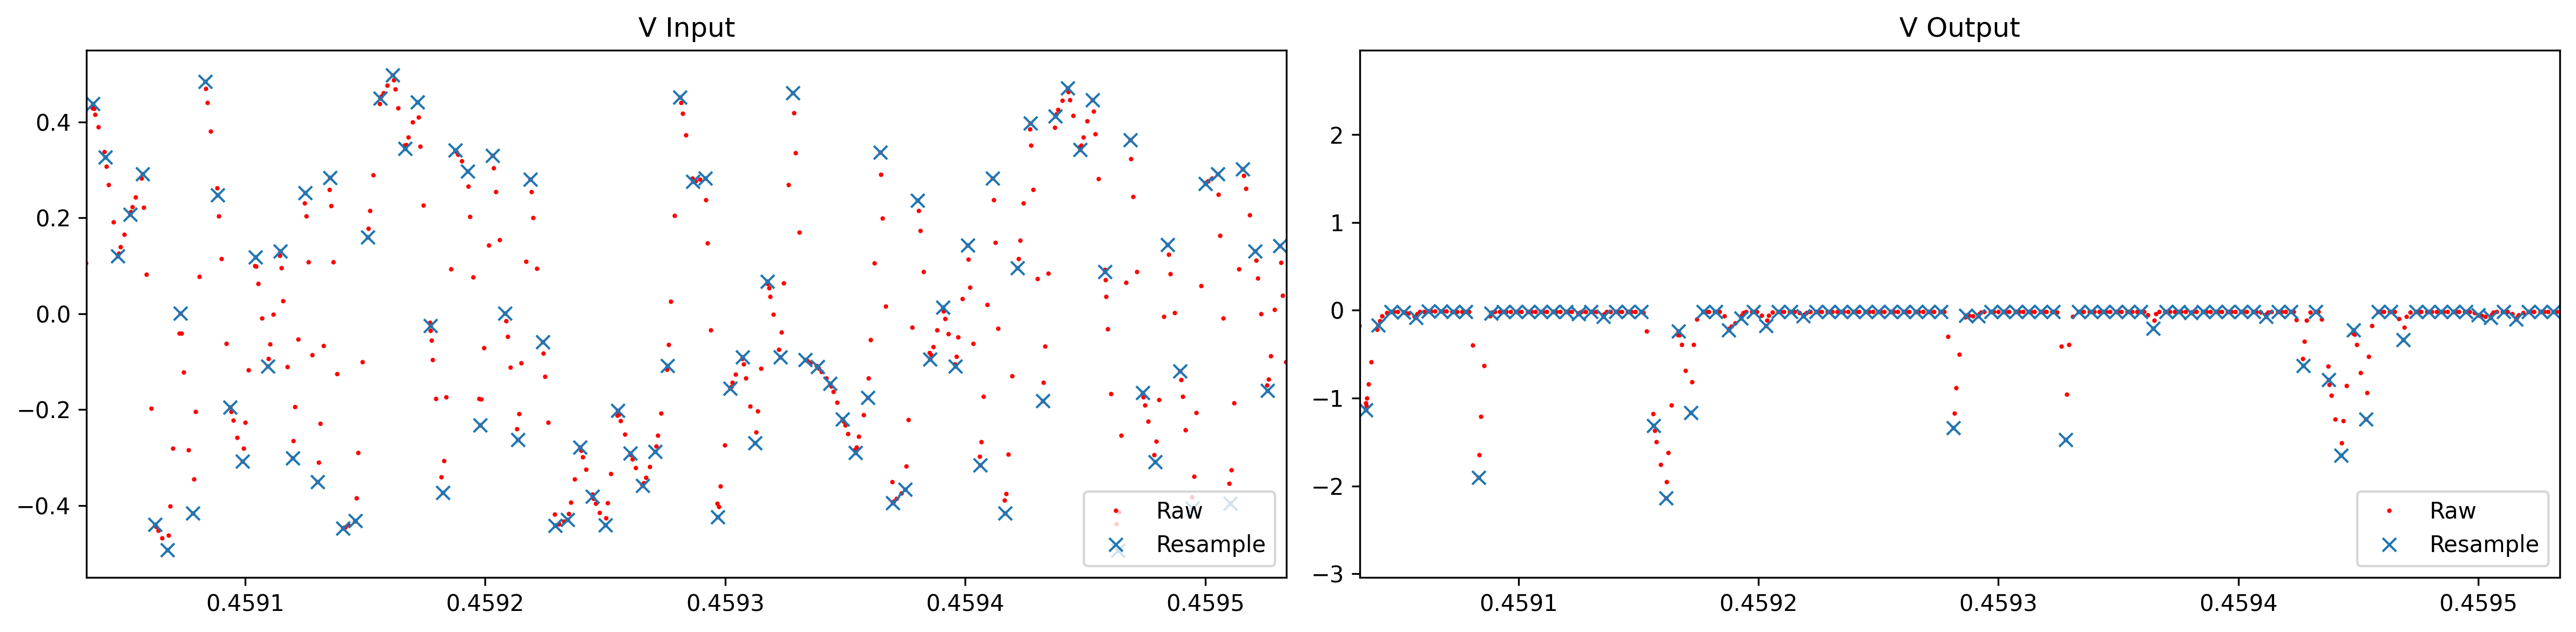

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), dpi=300)

plot_duration = 5e-4
plot_start = np.random.uniform(0, time_duration - plot_duration)
plot_end = plot_start + plot_duration
xlim = (plot_start, plot_end)

markersize_raw = 1
markersize_resample = 6

ax1.plot(time_raw, v_in_raw, 'ro', markersize=markersize_raw, label='Raw')
ax1.plot(time_resample, v_in, 'x', markersize=markersize_resample, label='Resample')
ax1.set_xlim(xlim)
ax1.set_title('V Input')
ax1.legend(loc='lower right')

ax2.plot(time_raw, v_out_raw, 'ro', markersize=markersize_raw, label='Raw')
ax2.plot(time_resample, v_out, 'x', markersize=markersize_resample, label='Resample')
ax2.set_xlim(xlim)
ax2.set_title('V Output')
ax2.legend(loc='lower right')

fig.tight_layout()
plt.show()
plt.close('all')

## Neural WDF for Two-Port Resistor


In [7]:
class GlobalNorm1d(nn.Module):
    def __init__(self, input_features, eps=None, affine=True):
        super(GlobalNorm1d, self).__init__()
        
        if eps is None:
            eps = torch.finfo(torch.float32).eps
        self.register_buffer('eps', torch.tensor(eps, dtype=torch.float32))
        
        self.register_buffer('count', torch.tensor(0., dtype=torch.float32))
        self.register_buffer('mean', torch.zeros(input_features, dtype=torch.float32))
        self.register_buffer('var', torch.ones(input_features, dtype=torch.float32))
        
        self.affine = affine
        self.weight = nn.Parameter(torch.ones(input_features, dtype=torch.float32)) if affine else None 
        self.bias = nn.Parameter(torch.zeros(input_features, dtype=torch.float32)) if affine else None
    
    def update_statistics(self, x):
        with torch.no_grad():
            batch_mean = x.mean(dim=0).to(self.mean.device)
            batch_count = x.size(0)
            total_count = self.count + batch_count
            # Update mean
            delta = batch_mean - self.mean
            self.mean += delta * batch_count / total_count
            # Update variance
            ratio = (self.count - 1) / (total_count - 1)
            batch_var = (x - batch_mean).pow(2).sum(dim=0)
            weighted_delta_square = delta.pow(2) * self.count * batch_count / total_count
            self.var *= ratio
            self.var += (batch_var + weighted_delta_square) / (total_count - 1)
            # Update count
            self.count = total_count
            
    def forward(self, x):
        self.update_statistics(x) if self.training else None
        normalized_x = (x - self.mean) / (self.var + self.eps).sqrt()
        return normalized_x * self.weight + self.bias if self.affine else normalized_x
 

class TwoPort(nn.Module):
    def __init__(self):
        super(TwoPort, self).__init__()
        self.gn1 = GlobalNorm1d(5)
        self.linear1 = nn.Linear(5, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.gn1(x)

        x1 = self.linear1(x)
        x1 = F.relu(x1)

        x2 = self.linear2(x1) + x1
        x2 = F.relu(x2)

        x3 = self.linear3(x2)
        return x3

## Neural WDF for Fuzz Circuit


In [8]:
class FuzzStatic(nn.Module):
    def __init__(
            self,
            alpha_lin=0.5,
            alpha_vol=0.5,
            fs=48e3,
            s_path="../S.hdf5",
            z_path="../Z.hdf5",
            dtype=torch.float32
        ):
        super(FuzzStatic, self).__init__()
        self.dtype = dtype

        # Circuit parameters
        self.C71 = torch.tensor(4.7e-6, dtype=self.dtype)
        self.Rin = torch.tensor(22e3, dtype=self.dtype)
        self.R72 = torch.tensor(50e3, dtype=self.dtype)
        self.C81 = torch.tensor(4.7e-6, dtype=self.dtype)
        self.R81 = torch.tensor(22e3, dtype=self.dtype)
        self.Rout = torch.tensor(100e3, dtype=self.dtype)
        self.C91 = torch.tensor(4.7e-6, dtype=self.dtype)
        self.R_vol = torch.tensor(50e3, dtype=self.dtype)
        self.C94 = torch.tensor(4.7e-6, dtype=self.dtype)


        # User parameters
        self.alpha_lin = alpha_lin
        self.alpha_vol = alpha_vol
        self.fs = fs


        # WDF structure parameters
        # self.a_C71_ic = torch.nn.Parameter(torch.tensor(0.82249534, dtype=self.dtype))
        self.a_C71_ic = torch.tensor(0.0, dtype=self.dtype)
        # self.a_C81_ic = torch.nn.Parameter(torch.tensor(0.17373981, dtype=self.dtype))
        self.a_C81_ic = torch.tensor(0.0, dtype=self.dtype)
        # self.a_C91_ic = torch.nn.Parameter(torch.tensor(1.0372866e-12, dtype=self.dtype))
        self.a_C91_ic = torch.tensor(0.0, dtype=self.dtype)
        # self.a_C94_ic = torch.nn.Parameter(torch.tensor(8.8279715, dtype=self.dtype))
        self.a_C94_ic = torch.tensor(0.0, dtype=self.dtype)
        self.a_C71 = torch.tensor(0.0, dtype=self.dtype)
        self.a_C81 = torch.tensor(0.0, dtype=self.dtype)
        self.a_C91 = torch.tensor(0.0, dtype=self.dtype)
        self.a_C94 = torch.tensor(0.0, dtype=self.dtype)
        self.b_C71 = torch.tensor(0.0, dtype=self.dtype)
        self.b_C81 = torch.tensor(0.0, dtype=self.dtype)
        self.b_C91 = torch.tensor(0.0, dtype=self.dtype)
        self.b_C94 = torch.tensor(0.0, dtype=self.dtype)

        self.b_S71_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P72_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P81_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S91_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P92_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S93_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S94_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S71_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P81_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S91_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S94_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P72_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P81_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S91_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P92_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S93_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S94_2 = torch.tensor(0.0, dtype=self.dtype)

        self.a0 = torch.tensor(0.0, dtype=self.dtype)
        self.a1 = torch.tensor(0.0, dtype=self.dtype)
        self.a2 = torch.tensor(0.0, dtype=self.dtype)
        self.a3 = torch.tensor(0.0, dtype=self.dtype)
        self.a4 = torch.tensor(0.0, dtype=self.dtype)
        self.a5 = torch.tensor(9.0, dtype=self.dtype)
        self.b0 = torch.tensor(0.0, dtype=self.dtype)
        self.b1 = torch.tensor(0.0, dtype=self.dtype)
        self.b2 = torch.tensor(0.0, dtype=self.dtype)
        self.b3 = torch.tensor(0.0, dtype=self.dtype)
        self.b4 = torch.tensor(0.0, dtype=self.dtype)


        # WDF scattering matrices of series and parallel junctions
        self.S_S71, self.S_P72 = self.get_scattering_matrix_port7()
        self.S_P81 = self.get_scattering_matrix_port8()
        self.S_S91, self.S_P92, self.S_S93, self.S_S94 = self.get_scattering_matrix_port9()


        # WDF scattering matrix of the R-type junction
        self.fs_dict = {
            44.1e3 : 0,
            48e3   : 1,
            88.2e3 : 2,
            96e3   : 3,
            176.4e3: 4,
            192e3  : 5
        }
        # STEP 1: Load the scattering and free-parameter impedance matrices from the HDF5 file
        with h5py.File(s_path, "r") as file:
            self.S_matlab = torch.as_tensor(file["/S"][:].T).to(dtype=self.dtype)
        with h5py.File(z_path, "r") as file:
            self.Z_matlab = torch.as_tensor(file["/Z"][:].T).to(dtype=self.dtype)
        # STEP 2: Get the scattering and free-parameter impedance matrices for the given fs, alpha_lin, and alpha_vol
        self.S, self.S_forward, self.S_backward, self.Z, self.Z_root = self.get_scattering_matrix_rtype(
            alpha_lin=self.alpha_lin,
            alpha_vol=self.alpha_vol,
            fs=self.fs
        )
        

        # Initialize neural network of the two-port element
        self.two_port = TwoPort()

    def load_nn(self, path):
        self.two_port = torch.load(path)


    def get_scattering_matrix_port7(self, fs=None):
        fs = self.fs if fs == None else fs

        Z_R71 = self.Rin
        Z_C71 = 1 / (2 * fs * self.C71)
        Z_S71 = torch.stack((
            Z_R71 + Z_C71,
            Z_C71,
            Z_R71
        ))

        Z_R72 = self.R72
        Z_P72 = torch.stack((
            (Z_S71[0] * Z_R72) / (Z_S71[0] + Z_R72),
            Z_R72,
            Z_S71[0]
        ))
        return (
            self.get_scattering_matrix_B([1, 1, -1], Z_S71),
            self.get_scattering_matrix_Q([1, 1,  1], Z_P72)
        )


    def get_scattering_matrix_port8(self):
        Z_R81 = self.R81
        Z_C81 = 1 / (2 * self.fs * self.C81)
        Z_P81 = torch.stack((
            (Z_R81 * Z_C81) / (Z_R81 + Z_C81),
            Z_C81,
            Z_R81
        ))
        return self.get_scattering_matrix_Q([1, 1, 1], Z_P81)


    def get_scattering_matrix_port9(self, alpha_vol=None, fs=None):
        alpha_vol = self.alpha_vol if alpha_vol == None else alpha_vol
        fs = self.fs if fs == None else fs

        Z_R91 = self.Rout
        Z_C91 = 1 / (2 * fs * self.C91)
        Z_S91 = torch.stack((
            Z_R91 + Z_C91,
            Z_R91,
            Z_C91
        ))

        R92 = alpha_vol * self.R_vol 
        Z_R92 = R92
        Z_P92 = torch.stack((
            (Z_R92 * Z_S91[0]) / (Z_R92 + Z_S91[0]),
            Z_R92,
            Z_S91[0]
        ))        

        R93 = (1 - alpha_vol) * self.R_vol
        Z_R93 = R93
        Z_S93 = torch.stack((
            Z_R93 + Z_P92[0],
            Z_R93,
            Z_P92[0]
        ))
        
        Z_C94 = 1 / (2 * fs * self.C94)
        Z_S94 = torch.stack((
            Z_C94 + Z_S93[0],
            Z_C94,
            Z_S93[0]
        ))
        
        return (
            self.get_scattering_matrix_B([ 1, 1, 1], Z_S91),
            self.get_scattering_matrix_Q([ 1, 1, 1], Z_P92),
            self.get_scattering_matrix_B([ 1, 1, 1], Z_S93),
            self.get_scattering_matrix_B([-1, 1, 1], Z_S94)
        )


    def get_scattering_matrix_rtype(self, alpha_lin=None, alpha_vol=None, fs=None):
        fs = self.fs if fs == None else fs

        fs_index = self.fs_dict[fs]
        alpha_lin_index = round(alpha_lin * 100)
        alpha_vol_index = round(alpha_vol * 100)

        S = self.S_matlab[fs_index, alpha_lin_index, alpha_vol_index, :, :]
        S_forward = S[0:2, [6, 7, 8, 9]]
        S_backward = S[6:9, [0, 1, 6, 7, 8, 9]]

        Z = self.Z_matlab[fs_index, alpha_lin_index, alpha_vol_index, :, :]
        Z_root = Z[0:2, 0:2]

        return (
            S,
            S_forward,
            S_backward,
            Z,
            Z_root
        )


    def get_scattering_matrix_B(self, B, Z):
        # STEP 0: Formate the free-parameter impedance matrix Z and get the number of ports
        Z = torch.diag(Z)
        num_ports = Z.shape[0]
        
        # STEP 1: Formulate fundamental loop matrix of the series junction
        B = torch.tensor(B, dtype=self.dtype)
        if B.ndim == 1:
            B = B.unsqueeze(0)
        
        # STEP 2: Calculate the scattering matrix using the general WD junction method
        I = torch.eye(num_ports, dtype=self.dtype)
        S = I - 2 * Z @ B.T @ torch.inverse(B @ Z @ B.T) @ B
        
        # STEP 3: Return the scattering matrix
        return S
    

    def get_scattering_matrix_Q(self, Q, Z):
        # STEP 0: Formate the free-parameter impedance matrix Z and get the number of ports
        Z = torch.diag(Z)
        num_ports = Z.shape[0]
        
        # STEP 1: Formulate fundamental cut-set matrix
        Q = torch.tensor(Q, dtype=self.dtype)
        if Q.ndim == 1:
            Q = Q.unsqueeze(0)
        
        # STEP 2: Calculate the scattering matrix using the general WD junction method
        I = torch.eye(num_ports, dtype=self.dtype)
        Z_inv = torch.inverse(Z)
        S = 2 * Q.T @ torch.inverse(Q @ Z_inv @ Q.T) @ Q @ Z_inv - I
        
        # STEP 3: Return the scattering matrix
        return S


    def reset_waves(self):
        self.a_C71 = self.a_C71_ic * 1.0
        self.a_C81 = self.a_C81_ic * 1.0
        self.a_C91 = self.a_C91_ic * 1.0
        self.a_C94 = self.a_C94_ic * 1.0
        self.b_C71 = torch.tensor(0.0, dtype=self.dtype)
        self.b_C81 = torch.tensor(0.0, dtype=self.dtype)
        self.b_C91 = torch.tensor(0.0, dtype=self.dtype)
        self.b_C94 = torch.tensor(0.0, dtype=self.dtype)

        self.b_S71_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P72_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P81_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S91_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P92_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S93_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S94_0 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S71_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P81_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S91_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S94_1 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P72_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P81_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S91_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_P92_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S93_2 = torch.tensor(0.0, dtype=self.dtype)
        self.b_S94_2 = torch.tensor(0.0, dtype=self.dtype)

        self.a0 = torch.tensor(0.0, dtype=self.dtype)
        self.a1 = torch.tensor(0.0, dtype=self.dtype)
        self.a2 = torch.tensor(0.0, dtype=self.dtype)
        self.a3 = torch.tensor(0.0, dtype=self.dtype)
        self.a4 = torch.tensor(0.0, dtype=self.dtype)
        self.a5 = torch.tensor(9.0, dtype=self.dtype)
        self.b0 = torch.tensor(0.0, dtype=self.dtype)
        self.b1 = torch.tensor(0.0, dtype=self.dtype)
        self.b2 = torch.tensor(0.0, dtype=self.dtype)
        self.b3 = torch.tensor(0.0, dtype=self.dtype)
        self.b4 = torch.tensor(0.0, dtype=self.dtype)


    def solve_dc(self, dc_in=0.0, epsilon=1e-10):
        # STEP 0: Reset the waves to DC=0 state
        self.a_C71 = torch.tensor(-3.7427606943372482, dtype=self.dtype)
        self.a_C81 = torch.tensor(1.8297941172302856, dtype=self.dtype)
        self.a_C91 = torch.tensor(-4.440665733659135e-12, dtype=self.dtype)
        self.a_C94 = torch.tensor(-5.598253191650242, dtype=self.dtype)
        # # Check if the input is DC=0
        # if dc_in == 0.0:
        #     return self.a_C71, self.a_C81, self.a_C91, self.a_C94

        # STEP 1: Prepare the WDF structure for the DC analysis
        is_stable = False
        error_eps = epsilon

        # STEP 2: Iterate the WDF structure until the states of capacitors and inductors are stable
        ii = 0
        while not is_stable:
            ii += 1

            # Manage capacitors and inductors' states
            self.b_C71 = self.a_C71
            self.b_C81 = self.a_C81
            self.b_C91 = self.a_C91
            self.b_C94 = self.a_C94

            # Forward scanning
            self.b_S71_0 = self.S_S71[0, 1] * self.b_C71 + self.S_S71[0, 2] * dc_in
            self.b_P72_0 = self.S_P72[0, 2] * self.b_S71_0
            self.b_P81_0 = self.S_P81[0, 1] * self.b_C81
            self.b_S91_0 = self.S_S91[0, 2] * self.b_C91
            self.b_P92_0 = self.S_P92[0, 2] * self.b_S91_0
            self.b_S93_0 = self.S_S93[0, 2] * self.b_P92_0
            self.b_S94_0 = self.S_S94[0, 1] * self.b_C94 + self.S_S94[0, 2] * self.b_S93_0
            
            self.a2 = self.b_P72_0
            self.a3 = self.b_P81_0
            self.a4 = self.b_S94_0

            # Local scattering
            self.b0, self.b1 = self.S_forward @ torch.stack([self.a2, self.a3, self.a4, self.a5])
            self.a0, self.a1 = self.two_port(torch.stack([self.b0, self.b1]))
            self.b2, self.b3, self.b4 = self.S_backward @ torch.stack([self.a0, self.a1, self.a2, self.a3, self.a4, self.a5])

            # Backward scanning
            self.b_P72_2 = self.S_P72[2, 0] * self.b2 + self.S_P72[2, 2] * self.b_S71_0
            self.b_S71_1 = self.S_S71[1, 0] * self.b_P72_2 + self.S_S71[1, 1] * self.b_C71 + self.S_S71[1, 2] * dc_in
            self.b_P81_1 = self.S_P81[1, 0] * self.b3 + self.S_P81[1, 1] * self.b_C81
            self.b_S94_1, self.b_S94_2 = self.S_S94[1:3, :] @ torch.stack([self.b4, self.b_C94, self.b_S93_0])
            self.b_S93_2 = self.S_S93[2, 0] * self.b_S94_2 + self.S_S93[2, 2] * self.b_P92_0
            self.b_P92_2 = self.S_P92[2, 0] * self.b_S93_2 + self.S_P92[2, 2] * self.b_S91_0
            self.b_S91_2 = self.S_S91[2, 0] * self.b_P92_2 + self.S_S91[2, 2] * self.b_C91

            # Check if the states of capacitors and inductors are stable
            if (
                torch.abs(self.b_C71 - self.b_S71_1) > error_eps
                or torch.abs(self.b_C81 - self.b_P81_1) > error_eps
                or torch.abs(self.b_C91 - self.b_S91_2) > error_eps
                or torch.abs(self.b_C94 - self.b_S94_1) > error_eps
            ):
                self.a_C71 = self.b_S71_1
                self.a_C81 = self.b_P81_1
                self.a_C91 = self.b_S91_2
                self.a_C94 = self.b_S94_1
            else:
                is_stable = True

        print("Iterations:", ii)
        print(
            "Stable states:\n  C71:",
            self.a_C71,
            "\n  C81:",
            self.a_C81,
            "\n  C91:",
            self.a_C91,
            "\n  C94:",
            self.a_C94,
        )

        return self.a_C71, self.a_C81, self.a_C91, self.a_C94


    def set_capacitors_initial_conditions(self, a_C71, a_C81, a_C91, a_C94):
        self.a_C71 = a_C71
        self.a_C81 = a_C81
        self.a_C91 = a_C91
        self.a_C94 = a_C94


    def forward(self, vin, alpha_lin, alpha_vol):
        vout = torch.zeros_like(vin)

        for i in range(vin.shape[0]):
            # Get r-type junction scattering matrix
            self.S_S91, self.S_P92, self.S_S93, self.S_S94 = self.get_scattering_matrix_port9(alpha_vol=alpha_vol[i].item())
            self.S, self.S_forward, self.S_backward, self.Z, self.Z_root = self.get_scattering_matrix_rtype(
                alpha_lin=alpha_lin[i].item(),
                alpha_vol=alpha_vol[i].item()
            )

            # Manage capacitors and inductors' states
            self.b_C71 = self.a_C71
            self.b_C81 = self.a_C81
            self.b_C91 = self.a_C91
            self.b_C94 = self.a_C94

            # Forward scanning
            self.b_S71_0 = self.S_S71[0, 1] * self.b_C71 + self.S_S71[0, 2] * vin[i, 0]
            self.b_P72_0 = self.S_P72[0, 2] * self.b_S71_0
            self.b_P81_0 = self.S_P81[0, 1] * self.b_C81
            self.b_S91_0 = self.S_S91[0, 2] * self.b_C91
            self.b_P92_0 = self.S_P92[0, 2] * self.b_S91_0
            self.b_S93_0 = self.S_S93[0, 2] * self.b_P92_0
            self.b_S94_0 = self.S_S94[0, 1] * self.b_C94 + self.S_S94[0, 2] * self.b_S93_0
            
            self.a2 = self.b_P72_0
            self.a3 = self.b_P81_0
            self.a4 = self.b_S94_0

            # Local scattering
            self.b0, self.b1 = self.S_forward @ torch.stack([self.a2, self.a3, self.a4, self.a5])
            self.a0, self.a1 = self.two_port(torch.stack([self.b0, self.b1, self.Z_root[0, 0], self.Z_root[0, 1], self.Z_root[1, 1]]))
            self.b2, self.b3, self.b4 = self.S_backward @ torch.stack([self.a0, self.a1, self.a2, self.a3, self.a4, self.a5])
            
            # Backward scanning
            self.b_P72_2 = self.S_P72[2, 0] * self.b2 + self.S_P72[2, 2] * self.b_S71_0
            self.b_S71_1 = self.S_S71[1, 0] * self.b_P72_2 + self.S_S71[1, 1] * self.b_C71 + self.S_S71[1, 2] * vin[i, 0]
            self.b_P81_1 = self.S_P81[1, 0] * self.b3 + self.S_P81[1, 1] * self.b_C81
            self.b_S94_1, self.b_S94_2 = self.S_S94[1:3, :] @ torch.stack([self.b4, self.b_C94, self.b_S93_0])
            self.b_S93_2 = self.S_S93[2, 0] * self.b_S94_2 + self.S_S93[2, 2] * self.b_P92_0
            self.b_P92_2 = self.S_P92[2, 0] * self.b_S93_2 + self.S_P92[2, 2] * self.b_S91_0
            self.b_S91_1 = self.S_S91[1, 0] * self.b_P92_2 + self.S_S91[1, 2] * self.b_C91
            self.b_S91_2 = self.S_S91[2, 0] * self.b_P92_2 + self.S_S91[2, 2] * self.b_C91
            
            self.a_C71 = self.b_S71_1
            self.a_C81 = self.b_P81_1
            self.a_C91 = self.b_S91_2
            self.a_C94 = self.b_S94_1
            
            vout[i, 0] = self.b_S91_1 / 2
        
        return vout


# vin, fs = librosa.load("./matlab/input_fuzz_static.wav", sr=None)
# vin = torch.tensor(vin, dtype=torch.float32).unsqueeze(1)

# model = FuzzStatic()
# model.init_waves()
# v_wdf = model(vin)

## Loss Function


In [22]:
class ESRLoss(nn.Module):
    def __init__(self):
        super(ESRLoss, self).__init__()

    def forward(self, y_true, y_pred):
        return torch.sum((y_true - y_pred)**2) / torch.sum(y_true**2)
    
class DCLoss(nn.Module):
    def __init__(self):
        super(DCLoss, self).__init__()

    def forward(self, y_true, y_pred):
        numerator = torch.abs(torch.mean(y_true - y_pred))**2
        denominator = torch.mean(y_true ** 2)
        return numerator / denominator

class CombinedSignalLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.MSE = nn.MSELoss()
        self.ESR = ESRLoss()

    def forward(self, y_target, y_pred):
        return self.MSE(y_target, y_pred) + self.ESR(y_target, y_pred)

## Training Loop


In [ ]:
v_in_tensor = torch.tensor(v_in, dtype=torch.float32).unsqueeze(1)
v_out_tensor = torch.tensor(v_out, dtype=torch.float32).unsqueeze(1)

model = FuzzStatic()
model.load_nn("../models/2x16.pth")

# freeze two-port neural network
for param in model.two_port.parameters():
    param.requires_grad = False

loss_func_train = nn.MSELoss()
loss_func_valid = nn.MSELoss()
lr = 1e-2
optimizer = torch.optim.NAdam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

# for name, param in model.named_parameters():
#     print(f"参数名: {name}")
#     print(f"   形状: {param.size()}")
#     print(f"   是否可训练: {'是' if param.requires_grad else '否'}")

for epoch in range(100):
    # model.train()
    model.eval()
    model.reset_waves()

    v_wdf = model(v_in_tensor)
    loss = loss_func_train(v_wdf, v_out_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # check learning rate
    scheduler.step(loss)
    if lr != scheduler.get_last_lr():
        lr = scheduler.get_last_lr()
        print(f"Learning rate changed to {lr[0]:.2e}")
    
    print(f"Epoch {epoch+1}: Combined = {loss.item():.5e}")

In [ ]:
plt.figure(figsize=(16, 4), dpi=300)
plt.plot(v_out, linewidth=1, label='V Out')
plt.plot(v_wdf.detach().numpy(), linewidth=1, label='V WDF')
plt.grid(alpha=0.25)

In [61]:
print(model.a_C71_ic.data)
print(model.a_C81_ic.data)
print(model.a_C91_ic.data)
print(model.a_C94_ic.data)

tensor(0.6507)
tensor(0.0006)
tensor(0.)
tensor(9.0007)


In [12]:
v_in_tensor = torch.tensor(v_in, dtype=torch.float32).reshape(-1, 1)
v_out_tensor = torch.tensor(v_out, dtype=torch.float32).reshape(-1, 1)
alpha_lin[0] = alpha_lin[1]
alpha_vol[0] = alpha_vol[1]
alpha_lin_tensor = torch.tensor(alpha_lin, dtype=torch.float32)
alpha_vol_tensor = torch.tensor(alpha_vol, dtype=torch.float32)

model = FuzzStatic(fs=fs_target)
model.load_nn("../models/2x16.pth")
model.reset_waves()
with torch.no_grad():
    model.eval()
    v_out_wdf = model(v_in_tensor, alpha_lin_tensor, alpha_vol_tensor)

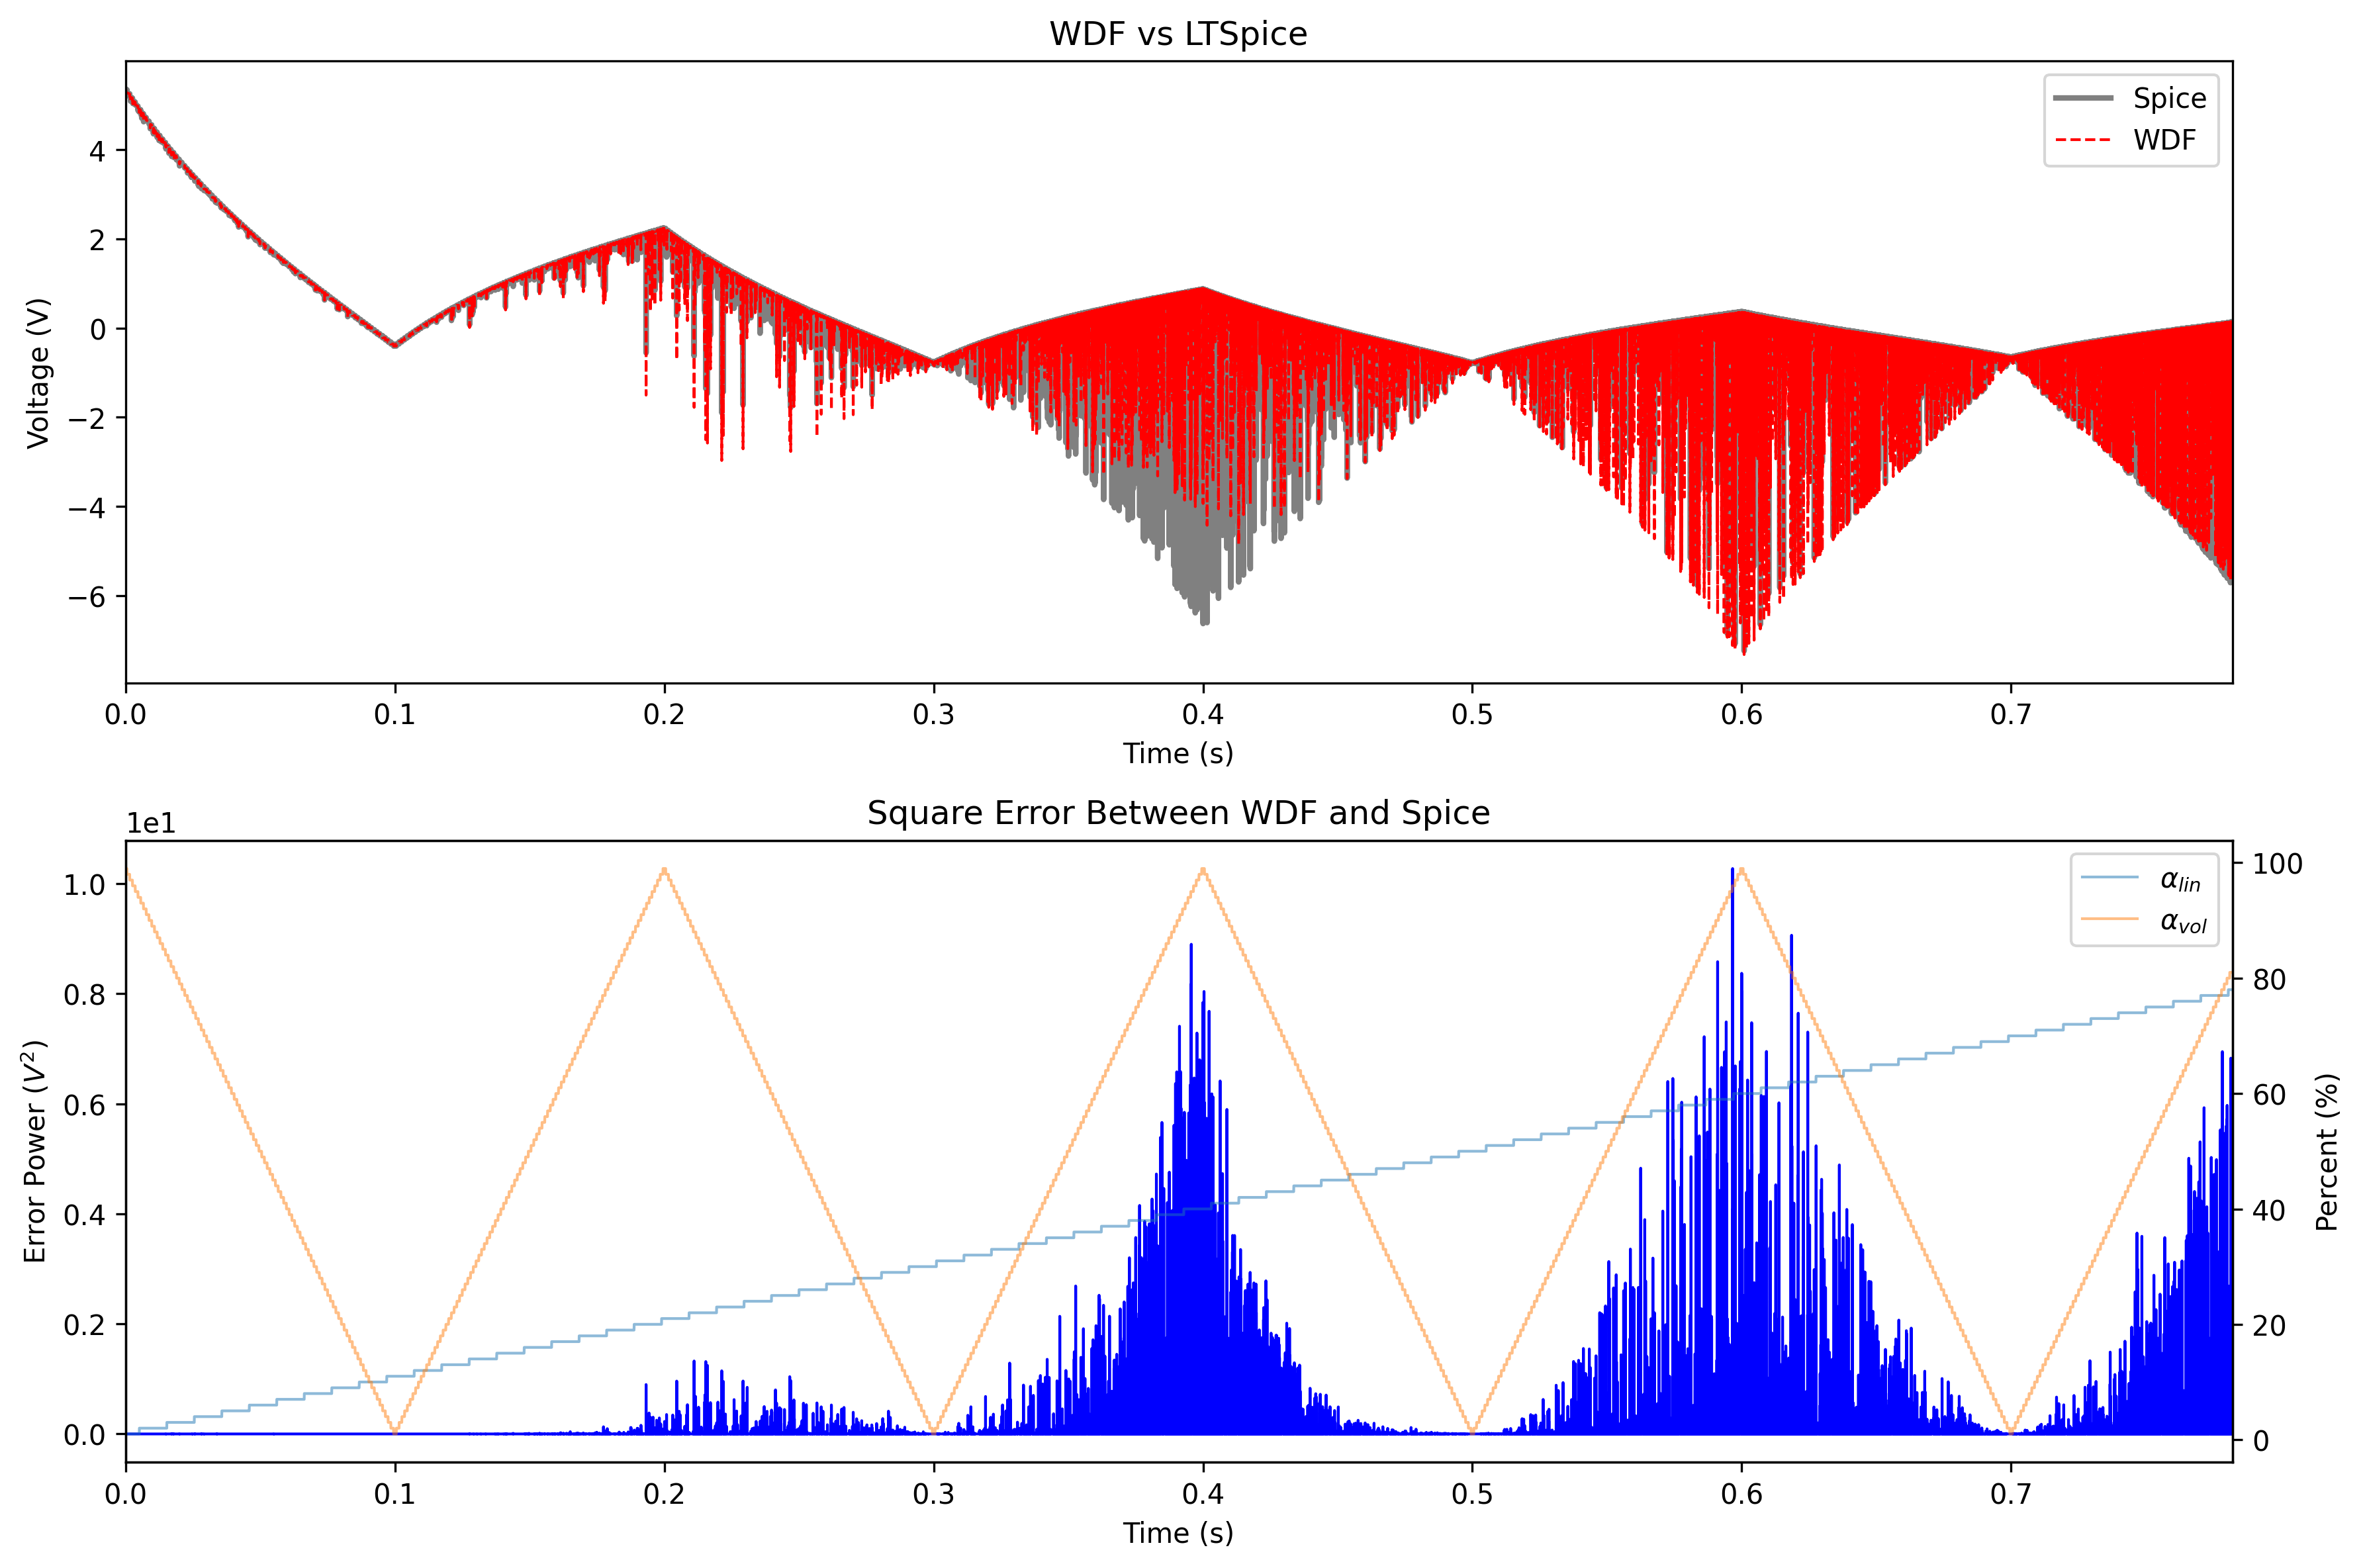

MSE = 6.768e-02


In [13]:
plot_duration = time_duration
plot_start = 0
plot_end = plot_start + plot_duration
linewidth_spice = 2
linewidth_wdf = 1
grid_alpha = 0.25

figsize = (12, 8)
xlim = (plot_start, plot_end)
# xlim = (0.4165, 0.4175)

v_wdf_np = v_out_wdf.detach().numpy().squeeze()
v_spice_np = v_out
y_axis = np.linspace(0, v_wdf_np.shape[0] / fs_target, v_wdf_np.shape[0])

# 创建一个图形和两个子图（ax1 和 ax2）
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, dpi=300)

# 在第一个子图上绘制原始信号对比
ax1.plot(y_axis, v_spice_np, color="grey", linewidth=linewidth_spice, label="Spice")
ax1.plot(y_axis, v_wdf_np, color="red", linewidth=linewidth_wdf, linestyle='--', label="WDF")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Voltage (V)")
ax1.set_title("WDF vs LTSpice")
ax1.legend(loc="upper right")
ax1.set_xlim(xlim)

# 计算差值信号square error
square_error = (v_spice_np - v_wdf_np) ** 2
MSE = np.mean(square_error)

# 在第二个子图上绘制差值信号图
ax2.plot(y_axis, square_error, color="blue", linewidth=1)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel(r"Error Power ($V^{2}$)")
ax2.set_title("Square Error Between WDF and Spice")
ax2.set_xlim(xlim)
# ax2.set_ylim((-1e-1, 1e-1))
ax2.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax21 = ax2.twinx()
ax21.plot(y_axis, alpha_lin*100, linewidth=1, alpha=0.5, label=r"$\alpha_{lin}$")
ax21.plot(y_axis, alpha_vol*100, linewidth=1, alpha=0.5, label=r"$\alpha_{vol}$")
ax21.set_ylabel("Percent (%)")
ax21.legend(loc="upper right")

plt.tight_layout()
plt.show()
plt.close("all")

print(f"MSE = {MSE:.3e}")